In [85]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [86]:
# tmp functional
def latexify_significancy_table(statistics, pvalues, corrflag=True, columnsname=[], rowsname=[]):
    # statistics is 2d array with the scores for two conditions
    def color_positive(val):
        """
        Takes a scalar and returns a string with
        the css property `'color: green'` for positive
        strings, black otherwise.
        """
        if val[-1] == '*':
            if val[0] == '-':
                color = 'blue'
            else:
                color = 'red'
        else:
            color = 'black'
        return 'color: %s' % color
    
    def bold(val):
        if val[-1] == '*':
            return "font-weight: bold"
    
    df    = pd.DataFrame.from_records(np.round(statistics,3))
    sigdf = pd.DataFrame.from_records(pvalues).applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
    signidf = (df.round(3).astype(str) + sigdf)

    if corrflag:
        signidf = signidf.style.applymap(color_positive)
    else:
        signidf = signidf.style.applymap(bold)
        
    if len(columnsname) != 0 and len(rowsname) != 0:
        signidf.data.columns = [s[:5] for s in columnsname]
        signidf.data.index = rowsname
    
    print(signidf.to_latex(
    caption="Selected stock correlation and simple statistics.",
    clines="skip-last;data",
    convert_css=True,
    position_float="centering",
    multicol_align="|c|",
    hrules=True))    

## Table of Contents
- [Timeseries Comparison](#comparison)
- [GLM](#weightings)
- [Visualization of Correlation and Movie (Side by Side)](#visualization)

<a class="anchor" id="comparison"></a>
### Timeseries Comparison 
Comparison between item timeseries and centroid of region timeseries

We have choices to either compute correlation between subjects and aggregated emotions or group level and aggregated emotions. We as well introduce other movies for the same subject in order to do permutation testing.

In [75]:
# 1. Loading Gradient Example
networks = list(index2region.keys())
moviename = 'Sintel'

# G_movie, varM = load('./resources/dynamic_grad/group_level414/{}_40_grad.pkl'.format(moviename))
G_movie, varM = load('./resources/dynamic_grad/group_level414/{}_40_1_grad.pkl'.format(moviename))
# G_movie, varM = load('./resources/dynamic_grad/group_level414/{}_80_2_grad.pkl'.format(moviename))
# we keep only first 3 gradients
G_movie  = G_movie[:,:,:3]

# 2. Loading Matching Emotion Track
full_df  = pd.read_csv('./data/emotion_compileBIDS.csv')
emo_df   = full_df[full_df['filename']=='W_{}13.csv'.format(moviename)]
other_df = full_df[full_df['filename']!='W_{}13.csv'.format(moviename)]

# 3. Loading Low-Level Features
luminance = np.loadtxt('./resources/llf-features_extracted/SintelLuminance.txt', delimiter=',')
audio     = np.loadtxt('./resources/llf-features_extracted/SintelAudio.txt', delimiter=',')
diffenerg = np.loadtxt('./resources/llf-features_extracted/SinteldiffNrg.txt', delimiter=',')
k         = G_movie.shape[0] - 1
# downsample to rate for window rate 
luminance = zscore(local_average(luminance, ks=31)[:k])
audio     = zscore(local_average(audio[:,0], ks=52)[:k])
diffenerg = zscore(local_average(diffenerg, ks=31)[:k])
llf       = [luminance, audio, diffenerg]

#### Example of Metrics
We use the following 4 metrics:
- network variance/position
- network volume
- intra-network distances
- explained variance from eigendecomposition

Text(0.5, 1.0, 'Explained Variance')

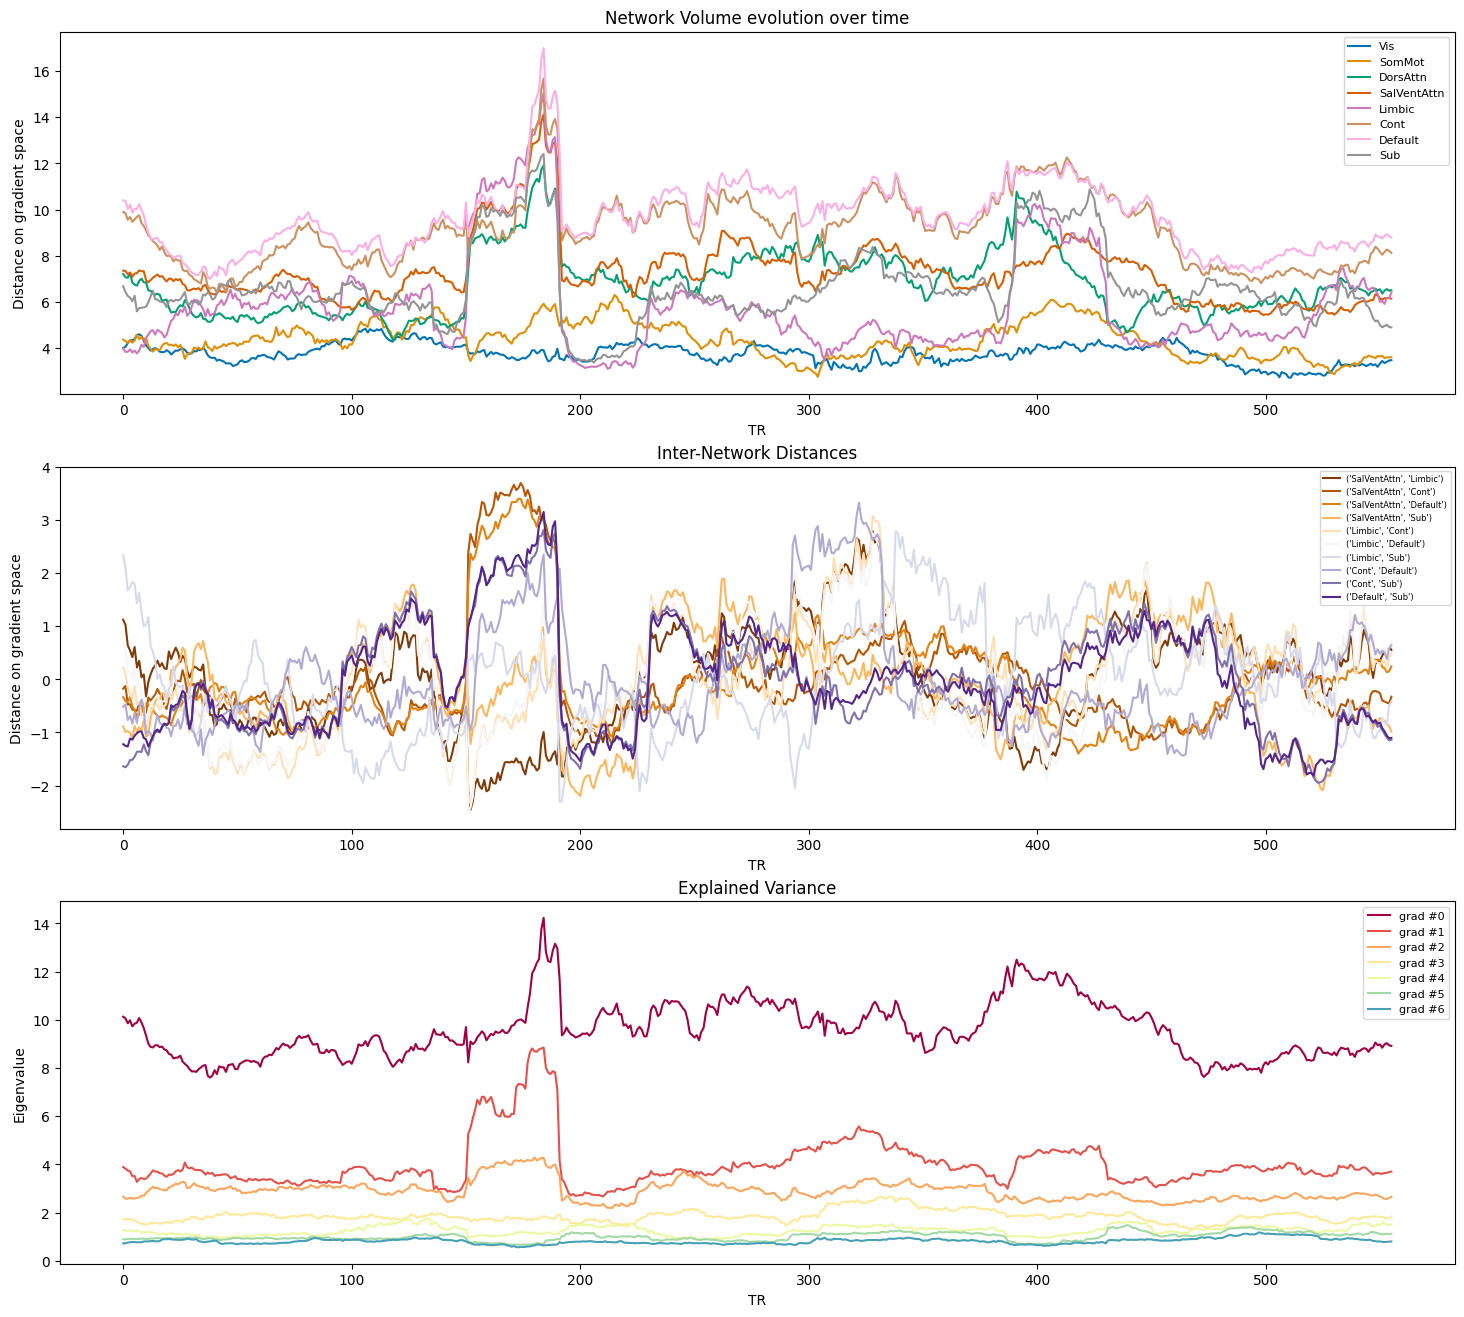

In [76]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)

fig, ax = plt.subplots(3,1,figsize=(18,16))

# # METRIC 1
# nb = len(networks)
# grad_idx = 0
# for idx, R in enumerate(networks):
#     y = network_position(G_movie, R, grad_idx)
#     x = np.arange(len(y))
#     error = network_variance(G_movie, R, grad_idx)
#     ax[0].plot(x,y, label=R, color=my_cmap.colors[idx])

#     # ax[0].fill_between(x, y-error, y+error, alpha=0.4)
#     ax[0].legend(loc=1, prop={'size':8})
#     ax[0].set_xlabel('TR')
#     ax[0].set_ylabel('Distance on gradient space')
# # ax[0].axvline(x=wash, label='after wash')
# ax[0].set_title("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

# METRIC 1
nb = len(networks)
for idx, R in enumerate(networks):
    y = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    x = np.arange(len(y))

    ax[0].plot(x,y, label=R, color=my_cmap.colors[idx])
    ax[0].legend(loc=1, prop={'size':8})    
    ax[0].set_xlabel('TR')
    ax[0].set_ylabel('Distance on gradient space')
ax[0].set_title("Network Volume evolution over time")

# METRIC 2
pairs = [] 
for net in networks:
    for net2 in networks:
        if net == net2: continue
        if ((net,net2) not in pairs) and ((net2,net) not in pairs):
            pairs.append((net,net2))
pairs = pairs[-10:]
nb = len(pairs)
cm = plt.get_cmap('PuOr')
ax[1].set_prop_cycle(color=[cm(1.*i/nb) for i in range(nb)])
for idx, pair in enumerate(pairs):
    p1,p2 = pair
    y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    x = np.arange(len(y))
    y = zscore(y)
    ax[1].plot(x,y, label=pair)
    ax[1].legend(loc=1, prop={'size':6}) 
    ax[1].set_xlabel('TR')
    ax[1].set_ylabel('Distance on gradient space')
ax[1].set_title("Inter-Network Distances")   

# METRIC 3
nb = varM.shape[1]-3
cm = plt.get_cmap('Spectral')
ax[2].set_prop_cycle(color=[cm(1.*i/nb) for i in range(nb)])
for idx, gradnb in enumerate(range(varM.shape[1]-3)):
    y = varM[:,gradnb]
    x = np.arange(len(y))
    ax[2].plot(x,y, label='grad #{}'.format(gradnb))
    ax[2].legend(loc=1, prop={'size':8}) 
    ax[2].set_xlabel('TR')
    ax[2].set_ylabel('Eigenvalue')
ax[2].set_title("Explained Variance") 

# plt.suptitle("Metrics evaluations".format(grad_idx + 1), size=20)

Emotions timecourses absolute

In [77]:
absemo_df = pd.read_csv('./data/emotion_compileBIDS.csv')
absemo_df = absemo_df[absemo_df['filename']=='W_{}13.csv'.format(moviename)]

Text(0.5, 1.0, 'Aggregated Absolute Emotion time series')

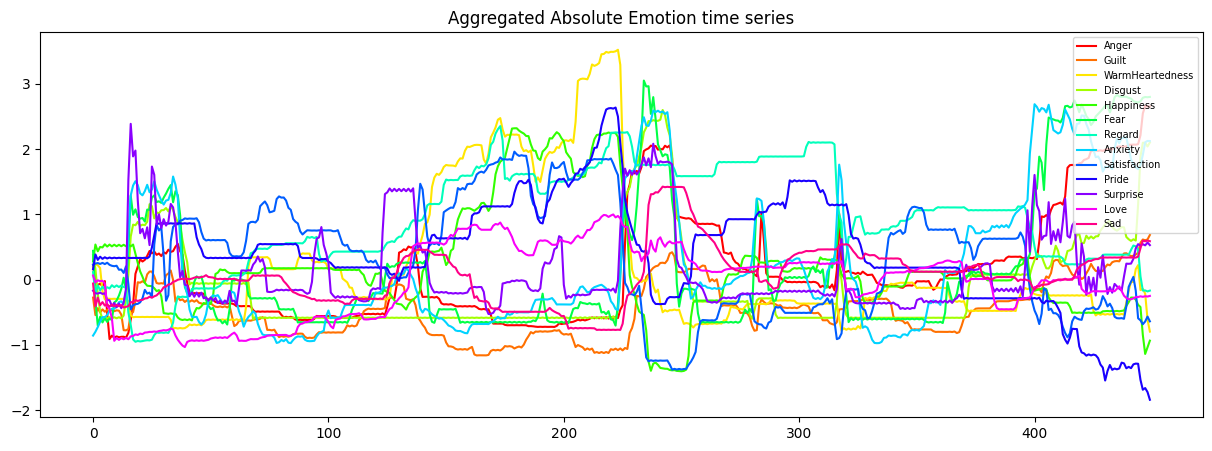

In [78]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

NUM_COLORS = len(select)
cm     = plt.get_cmap('hsv')
fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for emotion in select:
    emo_series = np.array(absemo_df[absemo_df.item==emotion]['score'])[:450]
    ax.plot(emo_series, label=emotion)

ax.legend(loc=1, prop={'size':7})
ax.set_title("Aggregated Absolute Emotion time series")

#### Correlation brain maps with 7 networks
Compute correlation between a given metric and emotion series

In [79]:
def shift_series_nulldistribution(Y, othermoviesdf, emotion_df, smfactor=1):
    ret_nscore = np.zeros((len(select)))
    ret_score  = np.zeros((len(select)))

    z1 = zscore(Y)
    for jdx, emotion in enumerate(select):
        concat_other = np.array(othermoviesdf[othermoviesdf.item == emotion]['score'])
        emo_series   = np.array(emotion_df[emotion_df.item==emotion]['score'])
        smoothened   = overlap_add(emo_series, smfactor)
        z2           = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        ret_nscore[jdx] = nscore
        ret_score[jdx]  = corr
    
    return ret_score, ret_nscore

In [ ]:
# Grid for each network of correlation with emotions
grad_idx = 0
smfactor = 1

pairs = [] 
for net in networks:
    for net2 in networks:
        if net == net2: continue
        if ((net,net2) not in pairs) and ((net2,net) not in pairs):
            pairs.append((net,net2))
            
n = len(pairs)
m = len(select)

nb_metric = 5
scores  = np.zeros((nb_metric, n,m))
nscores = np.zeros((nb_metric, n,m))

# METRIC 1
for idx, pair in enumerate(tqdm(pairs)):
    p1,p2 = pair
    y     = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    ret_score, ret_nscore = shift_series_nulldistribution(y, other_df, emo_df, smfactor=smfactor)
    scores[0, idx]  = ret_score
    nscores[0, idx] = ret_nscore

# METRIC 2
for idx, R in enumerate(tqdm(networks)):
    y  = network_variance(G_movie, R, grad_idx)
    ret_score, ret_nscore = shift_series_nulldistribution(y, other_df, emo_df, smfactor=smfactor)
    scores[1, idx]  = ret_score
    nscores[1, idx] = ret_nscore
    
# METRIC 3
for idx, R in enumerate(tqdm(networks)):
    y  = np.asarray([network_volume(G_movie[t], R)
                    for t in range(len(G_movie))])
    ret_score, ret_nscore = shift_series_nulldistribution(y, other_df, emo_df, smfactor=smfactor)
    scores[2, idx]  = ret_score
    nscores[2, idx] = ret_nscore

# METRIC 4
for idx, R in enumerate(tqdm(networks)):
    y  = varM[:,idx]
    ret_score, ret_nscore = shift_series_nulldistribution(y, other_df, emo_df, smfactor=smfactor)
    scores[3, idx]  = ret_score
    nscores[3, idx] = ret_nscore    

# METRIC 5 -> which is the luminance audio and diff energy values that we want to potentially find correlation with
for idx, R in enumerate(tqdm(networks)):
    if idx >= 3: 
        continue
    y = llf[idx]
    ret_score, ret_nscore = shift_series_nulldistribution(y, other_df, emo_df, smfactor=smfactor)
    scores[4, idx]  = ret_score
    nscores[4, idx] = ret_nscore      


  0%|          | 0/28 [00:00<?, ?it/s]

#### Correlation brain maps with regions
Compute correlation between a given metric and emotion series

In [8]:
# For each region generate correlation with emotions
n = G_movie.shape[1]
m = len(select)

scores2 = np.zeros((n,m))

for idx in tqdm(range(n)):
    
#     y    = np.asarray([ np.sum([points_distance(G_movie[t,idx], G_movie[t,jdx],pmethod="L2")   
#                                 for jdx in range(len(G_movie[t,:])) ])
#             for t in range(len(G_movie))])
    y    = np.asarray([ points_distance(G_movie[t,idx], G_movie[t,:].mean(axis=0),pmethod="L2")
            for t in range(len(G_movie))])

    ret_score, _ = shift_series_nulldistribution(y, other_df, emo_df)
    scores2[idx] = ret_score

  0%|          | 0/414 [00:00<?, ?it/s]

In [11]:
# from matplotlib.font_manager import FontProperties

# xlabels = ["Pair of networks", "Networks", "Networks", "Gradients", "low-level-features"]
# titles  = ["Distribution of correlation score (Metric 1: Distance Inter-networks)",
#             "Distribution of correlation score (Metric 2: Variance of networks along 1 gradient)",
#             "Distribution of correlation score (Metric 3: Networks dispersion (volume))",
#             "Distribution of correlation score (Metric 4: Explained Variance)",
#             "Distribution of correlation score (Low-level Features)"]

# nb_metric = 5
# PALETTES = ['PuOr', 'colorblind', 'colorblind', 'Spectral', 'Spectral']
# fig,ax = plt.subplots(nb_metric ,1,figsize=(10,25))
# for m in range(nb_metric):
#     # MAKING TABLE
#     tabling = np.empty((8,14), dtype=np.object_)
#     for j in range(14):
#         for i in range(8):
#             if j == 0:
#                 if m == 0:
#                     p1,p2 = pairs[i] 
#                     tabling[i,j] = p1[:3] + '-' + p2[:3]
#                 elif m == 3:
#                     tabling[i,j] = 'Grad{}'.format(i+1)
#                 elif m == 4:
#                     if i >= 3:
#                         tabling[i,j] = " "
#                     else:    
#                         tabling[i,j] = ["luminance", "audio", "diff nrg"][i]
#                 else:
#                     tabling[i,j] = networks[i][:3]
#             else:
#                 tabling[i,j] = np.object_(np.round(scores[m][i,j-1],3))

#     concat_region = np.concatenate([[r] * scores[m].shape[1] for r in tabling[:,0]])
#     corr_score = {'networks': concat_region, 'mean-corr': np.abs(scores[m].flatten())}

# #     sns.barplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, palette=pal, errorbar=None)
# #     # sns.barplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd")
# #     # sns.swarmplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, color="r", alpha=.65)
# #     ax[m,0].set_title(titles[m], size=10)
# #     ax[m,0].tick_params(labelsize=7)
# #     ax[m,0].set_xlabel(xlabels[m], size=10)
# #     ax[m,0].set_ylabel('Pearson Correlation', size=10)

# #     ax[m,1].axis('tight')
# #     ax[m,1].axis('off')

# #     table = ax[m,1].table(cellText=tabling,
# #                             colLabels=[''] + [s[:5] for s in select],
# #                             loc='center')
    
#     ax[m].axis('tight')
#     ax[m].axis('off')
#     ax[m].set_title(titles[m], size=10)
#     table = ax[m].table(cellText=tabling,
#                             colLabels=[''] + [s[:5] for s in select],
#                             loc='center')    

#     for (row, col), cell in table.get_celld().items():
#         if (row == 0):
#             cell.set_text_props(fontproperties=FontProperties(weight='bold'))
#         if (col == 0):
#             cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            
#         # stress on which value is significant against null distribution
#         nscore  = nscores[m, row-1, col - 1]
#         nbstars = int(nscore < 0.01) + int(nscore < 0.05) + int(nscore < 0.1)
        
#         if row != 0 and col !=0 :
#             if m==4 and row >= 3 : continue
#             cell.get_text().set_text(str(tabling[row-1,col]) + '*' * nbstars)
            
#             if nbstars > 0:
#                 cell.set_text_props(fontproperties=FontProperties(weight='bold'))
#                 if tabling[row-1,col] > 0:
#                     cell.get_text().set_color('red')
#                 else:
#                     cell.get_text().set_color('blue')


    
# #     table.auto_set_font_size(False)
# #     table.set_fontsize(7)
# #     table.scale(1.35, 1.35)  # may help                        

# plt.suptitle("Correlation Metric VS Emotion (group) on : {}".format(moviename))
# plt.show()

##### For Metric 5: we monitor each parcels/regions separately 

In [ ]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = deepcopy(scores2.T)

grad = [None] * len(select)
for k in range(gs.shape[0]):
    # map the gradient to the parcels
#     lb,rb   = gs.min(), gs.max()
#     , color_range=[(lb,rb),(lb,rb)]
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='bwr',
                 color_bar=True, label_text=select, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)



#### Correlation brain maps with 400 parcellations

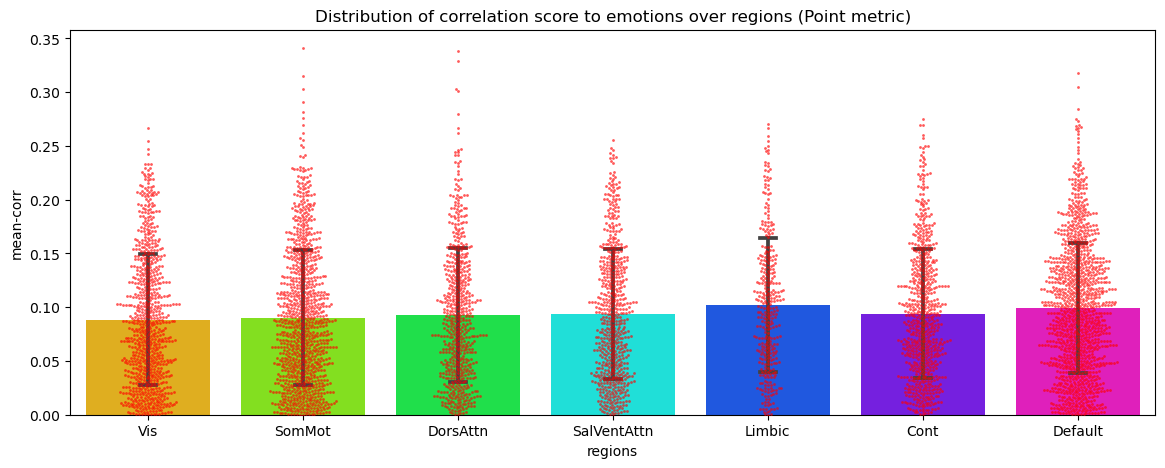

In [11]:
partial_region = load('./resources/region400yeo7.pkl')
partial_region = list(partial_region.values())

concat_region = np.concatenate([partial_region * scores2.shape[1]])
corr_score = {'regions': concat_region, 'mean-corr': np.abs(scores2.flatten())}

pal = sns.color_palette('hsv', len(networks))
plt.figure(figsize=(14,5))
sns.barplot(x="regions", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd", palette=pal)
sns.swarmplot(x="regions", y="mean-corr", data=corr_score, color="r", alpha=.65, size=2)
plt.title("Distribution of correlation score to emotions over regions (Point metric)")
plt.show()

##### Direct series visualization comparison (check)

In [26]:
tmp = [k.split('_')[0] for k in os.listdir('./resources/emo_metric_table/network_80_2_metric')]
tmp

['AfterTheRain',
 'BetweenViewings',
 'BigBuckBunny',
 'Chatter',
 'FirstBite',
 'LessonLearned',
 'Payload',
 'Sintel',
 'Spaceman',
 'Superhero',
 'TearsOfSteel',
 'TheSecretNumber',
 'ToClaireFromSonny',
 'YouAgain']

In [83]:
# nscores, scores = load('./resources/emo_metric_table/network_40_2_metric/YouAgain_40_2.pkl')

In [84]:
# latexify_significancy_table(scores[0][:8], nscores[0][:8], corrflag=True, columnsname=select, rowsname=networks)
latexify_significancy_table(scores[2][:8], nscores[2][:8], corrflag=True, columnsname=select, rowsname=networks)

\begin{table}
\centering
\caption{Selected stock correlation and simple statistics.}
\begin{tabular}{llllllllllllll}
\toprule
 & Anger & Guilt & WarmH & Disgu & Happi & Fear & Regar & Anxie & Satis & Pride & Surpr & Love & Sad \\
\midrule
Vis & \color{black} -0.157 & \color{black} -0.374 & \color{black} 0.183 & \color{black} 0.222 & \color{black} 0.318 & \color{black} 0.262 & \color{black} -0.361 & \color{black} 0.25 & \color{black} 0.318 & \color{black} 0.31 & \color{black} 0.231 & \color{black} -0.226 & \color{blue} -0.54* \\
SomMot & \color{black} -0.232 & \color{black} -0.442 & \color{red} 0.501** & \color{black} 0.094 & \color{red} 0.521* & \color{black} 0.232 & \color{black} -0.149 & \color{black} 0.282 & \color{red} 0.478* & \color{black} 0.369 & \color{black} 0.054 & \color{black} 0.011 & \color{blue} -0.565** \\
DorsAttn & \color{black} -0.238 & \color{black} -0.301 & \color{black} 0.301 & \color{black} -0.183 & \color{black} 0.431 & \color{black} -0.149 & \color{red} 0.414* &

Text(0.5, 0.98, 'Examples of correlations metric vs emotion')

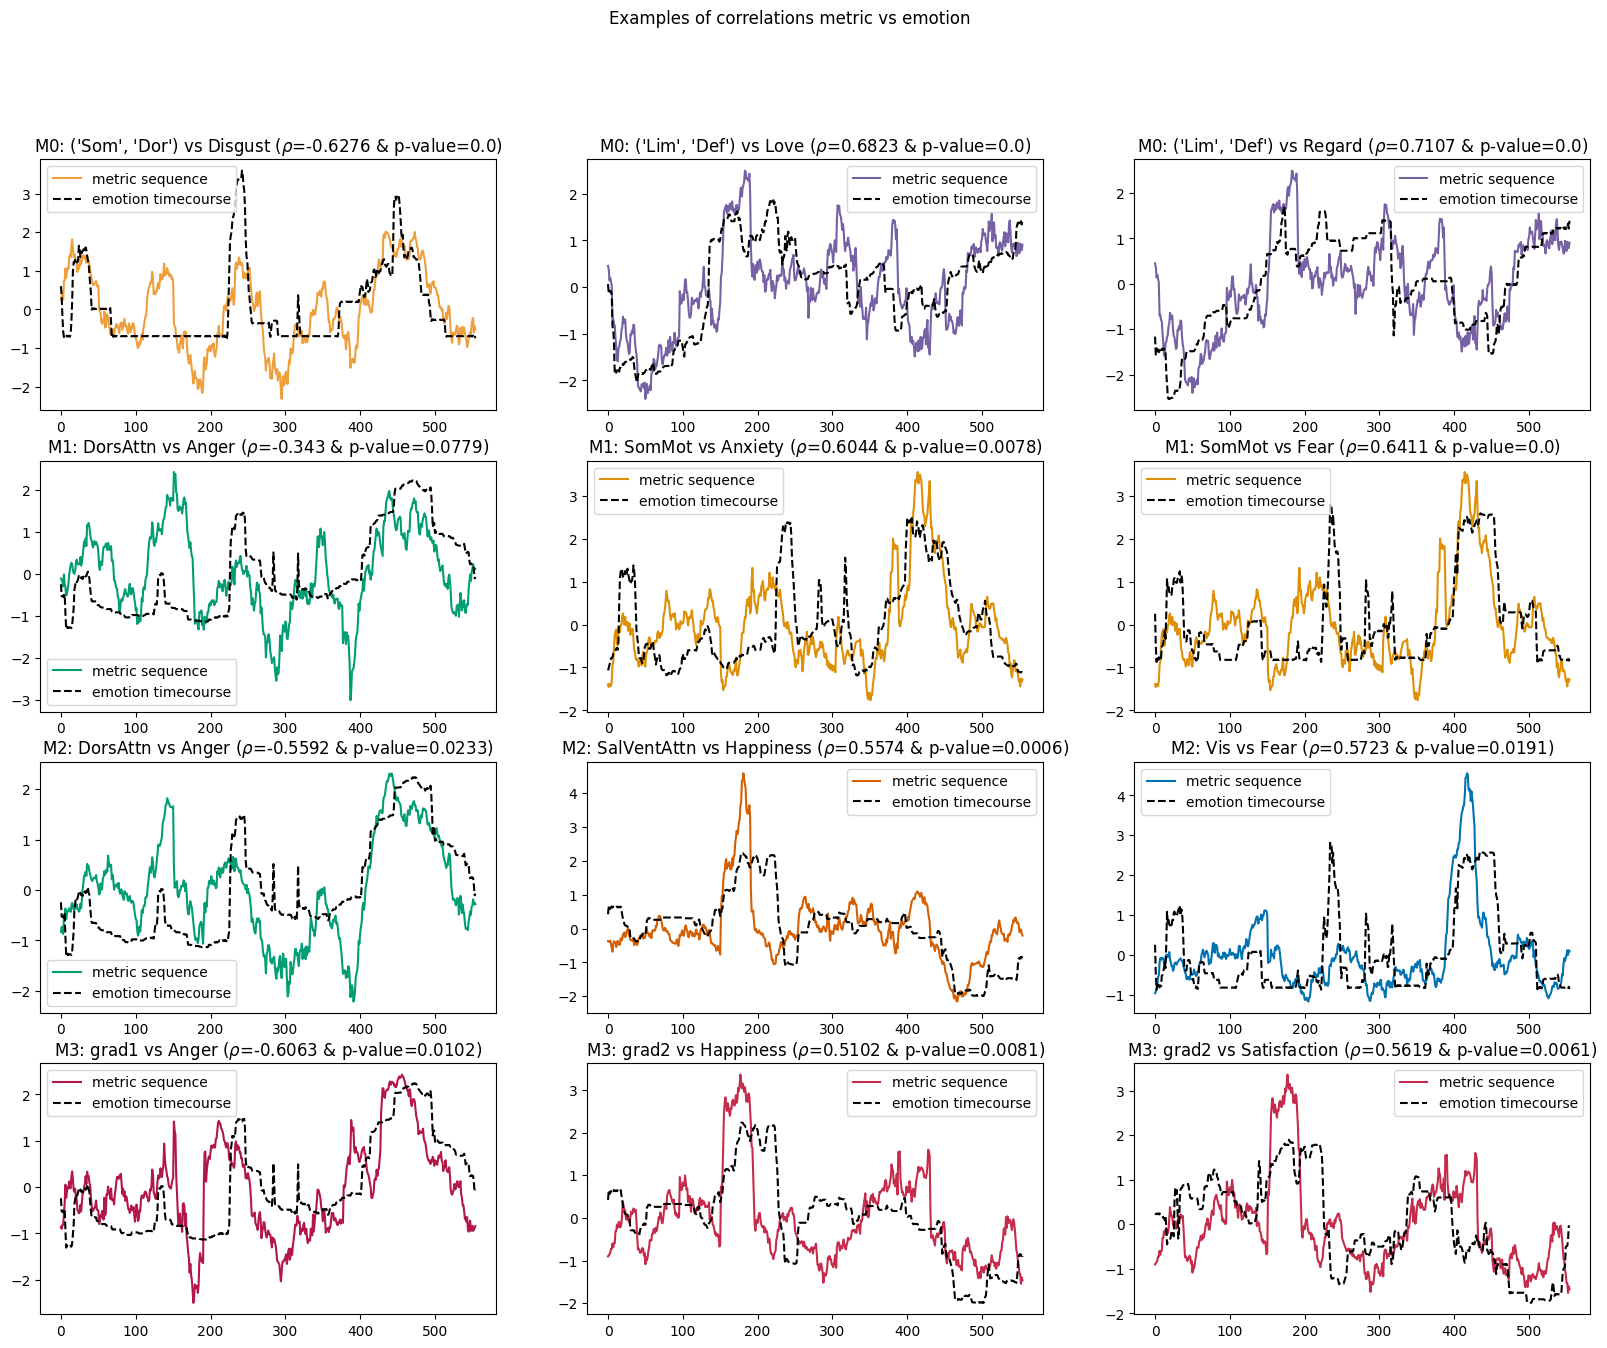

In [50]:
fig, ax = plt.subplots(4,3, figsize=(20,15))

# 1. compute the index with highest correlation in absolute
# (we take the 2 largest positive corr and 1 most negative corr for each metric)
indextosee = []
n          = np.prod(scores.shape[1:]) - 1
for m in range(nb_metric):
    indextosee.append(list(scores[m].flatten().argsort()[[0,n-1,n]]))
indextosee = np.stack(indextosee)


# 2. representative plots
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
for m in range(nb_metric-1):
    
    if m in [1,2]:
        colors = my_cmap.colors
    else:
        cm        = plt.get_cmap(PALETTES[m])
        cmEmo     = plt.get_cmap('hsv')
        colors    = [cm(1.*i/28) for i in range(28)]
        colorsEmo = [cmEmo(1.*i/13) for i in range(13)]
    for j in range(3):
        idx = indextosee[m][j]
        a,b = idx//13, idx%13
        if m == 0:
            p1,p2 = pairs[a]
            y  = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                            for t in range(len(G_movie))])
            label = p1[:3],p2[:3]
        elif m == 1:
            y     = network_variance(G_movie, networks[a], grad_idx)
            label = networks[a]
        elif m == 2:
            y     = np.asarray([network_volume(G_movie[t], networks[a])
                    for t in range(len(G_movie))])
            label = networks[a]
        else:
            y     = varM[:,a]
            label = "grad{}".format(a)
        
        z1 = zscore(y)
        # z1 = low_pass(z1, ks=40)
        concat_other = np.array(other_df[other_df.item == select[b]]['score'])
        emo_series   = np.array(emo_df[emo_df.item==select[b]]['score'])
        smoothened   = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])
        z1   = z1[:z2.shape[0]]
        corr = correlation_search(z1,z2, 0, 1)[0]
        _, nscore, _ = moviemix_stat_test(z1, z2, concat_other)
        if corr < 0:
            ax[m,j].plot(-z1, label='metric sequence', color=colors[a])
            ax[m,j].plot(z2, '--',label='emotion timecourse', color='k')
        else:
            ax[m,j].plot(z1, label='metric sequence', color=colors[a])
            ax[m,j].plot(z2, '--',label='emotion timecourse', color='k')
            
        ax[m,j].set_title("M{}: {} vs {} ({}={} & p-value={})".format(m,label,select[b],r"$\rho$",np.round(corr,4), np.round(nscore,4)))
        ax[m,j].legend()
plt.suptitle('Examples of correlations metric vs emotion')

### GLM
GLM Analysis with $\textbf{metric reconstruction}$ and $\textbf{emotion reconstruction}$ i.e we use as regressors (in turn):
- Emotions and low-level features
- Metrics

#### Loading

In [99]:
# 1. Loading Gradient Example
networks = list(index2region.keys())
moviename = 'Payload'

G_movie, varM = load('./resources/dynamic_grad/group_level414/{}_40_grad.pkl'.format(moviename))
# G_movie, varM = load('./resources/dynamic_grad/group_level_otherparam/{}_40_1_grad.pkl'.format(moviename))
# G_movie, varM = load('./resources/dynamic_grad/group_level_otherparam/{}_80_2_grad.pkl'.format(moviename))
G_movie = G_movie[:,:,:3]

# 2. Loading Matching Emotion Track
full_df  = pd.read_csv('./data/emotion_compileBIDS.csv')
emo_df   = full_df[full_df['filename']=='W_{}13.csv'.format(moviename)]
other_df = full_df[full_df['filename']!='W_{}13.csv'.format(moviename)]

# 3. Loading Low-Level Features
luminance = np.loadtxt('./resources/llf-features_extracted/PayloadLuminance.txt', delimiter=',')
audio     = np.loadtxt('./resources/llf-features_extracted/PayloadAudio.txt', delimiter=',')
diffenerg = np.loadtxt('./resources/llf-features_extracted/PayloaddiffNrg.txt', delimiter=',')
k         = G_movie.shape[0] - 1
# downsample to rate for window rate 
luminance = zscore(local_average(luminance, ks=31)[:k])
audio     = zscore(local_average(audio[:,0], ks=52)[:k])
diffenerg = zscore(local_average(diffenerg, ks=31)[:k])
llf       = [luminance, audio, diffenerg]

n, _ , _ = G_movie.shape
n        = n - 1  # window reason we resize by -1

#### GLM Regressors effect emotions and effect of low-level features

Text(0.5, 0.98, 'Low-Level Features')

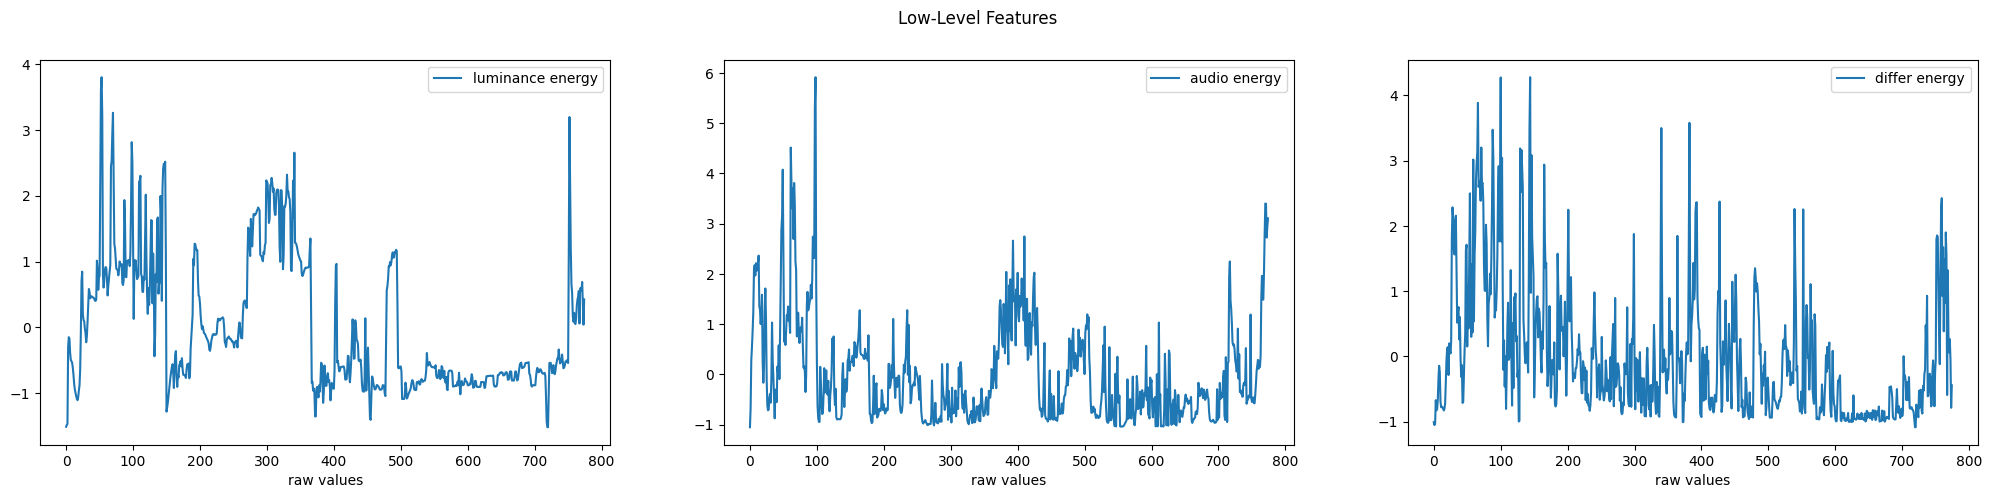

In [100]:
fig,ax = plt.subplots(1,3, figsize=(25,5))

ax[0].plot(luminance, label='luminance energy')
ax[1].plot(audio,label='audio energy')
ax[2].plot(diffenerg, label='differ energy')
for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel('raw values')
plt.suptitle('Low-Level Features')

##### Regressors Making

In [101]:
absemo_df = pd.read_csv('./data/emotion_compileBIDS.csv')
absemo_df = absemo_df[absemo_df['filename']=='W_{}13.csv'.format(moviename)]

regressors = [np.ones(n)]
smfactor   = 1
abs_val    = []
for b in range(len(select)):
    emotion    = select[b]
    emotion2   = select[b]
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])

    absemo_series = np.array(absemo_df[absemo_df.item==emotion2]['score'])
    abs_val.append(absemo_series)
    smoothened = overlap_add(emo_series, smfactor)
    z2         = zscore(smoothened[:n])
    regressors.append(z2)

# add regressors for low-level features    
regressors.append(luminance)
regressors.append(audio)
regressors.append(diffenerg)
regressors = np.stack(regressors)
abs_val    = np.asarray(abs_val)

##### GLM Fitting

In [102]:
# Obtain ratio of emotion timeseries
# ratio1 = np.abs(abs_val).mean(axis=1) / np.abs(abs_val).mean(axis=1).sum()

glmnet = {}

for i in range(len(networks)):
    # Computing to fit series
    y  = np.asarray([network_volume(G_movie[t], networks[i])
                for t in range(len(G_movie))])
    
    y = zscore(y)[:-1]

    # regress solving
    X = regressors.T

    beta = (np.linalg.inv(np.matmul(X.T, X)) @ X.T) @ y

    y_hat_meter = X @ beta

    N = y.size
    P = X.shape[1]
    df = (N - P)
    
    sigma_hat = np.sum((y - y_hat_meter) ** 2) / df
    design_variance_weight = design_variance(X, 1)
    # print("Degrees of freedom: %i" % df)
    # print("Sigma-hat (noise) is: %.3f" % sigma_hat)

    # t-stats
    t_meter = beta / np.sqrt(sigma_hat * design_variance_weight)

    # multiply by two to create a two-tailed p-value
    p_values = np.array([stats.t.sf(np.abs(t), df) * 2  for t in t_meter])

    glmnet[networks[i]] = (t_meter,p_values)

In [104]:
# rowsname = ['exp_var {}'.format(k+1) for k in range(len(networks))]
indexes = select + ['Luminance', 'Audio', 'Diffenerg']
indexes = [idx[:4] for idx in indexes]

statistics = np.asarray(list(glmnet.values()))[:,0,9:]
p_values   = np.asarray(list(glmnet.values()))[:,1,9:]
latexify_significancy_table(statistics, p_values, corrflag=False, columnsname=indexes[8:], 
                            rowsname=list(glmnet.keys()))


\begin{table}
\centering
\caption{Selected stock correlation and simple statistics.}
\begin{tabular}{lllllllll}
\toprule
 & Sati & Prid & Surp & Love & Sad & Lumi & Audi & Diff \\
\midrule
Vis & \bfseries 3.441*** & -0.831 & \bfseries -3.666*** & 0.121 & 0.164 & \bfseries 6.011*** & 0.825 & \bfseries -4.915*** \\
SomMot & \bfseries -7.308*** & -1.462 & 0.155 & -1.497 & \bfseries -5.999*** & \bfseries -2.809** & 1.096 & 0.052 \\
DorsAttn & \bfseries -2.536* & \bfseries 5.058*** & -1.447 & \bfseries 6.982*** & \bfseries -2.373* & \bfseries 2.317* & -0.254 & 1.49 \\
SalVentAttn & 1.741 & 0.252 & -0.443 & 1.007 & \bfseries 4.614*** & 0.858 & \bfseries 2.651** & 1.299 \\
Limbic & \bfseries 3.454*** & \bfseries -2.352* & -0.951 & -1.308 & \bfseries 9.278*** & \bfseries 2.6** & 1.483 & -1.478 \\
Cont & \bfseries -2.412* & -0.297 & -0.809 & \bfseries 2.531* & 1.732 & 0.15 & 1.832 & -0.684 \\
Default & -0.608 & -0.021 & -1.144 & \bfseries 1.974* & \bfseries 2.807** & 0.135 & \bfseries 2.042* & 

In [14]:
arr3 = ["vol_{}".format(n) for n in networks]

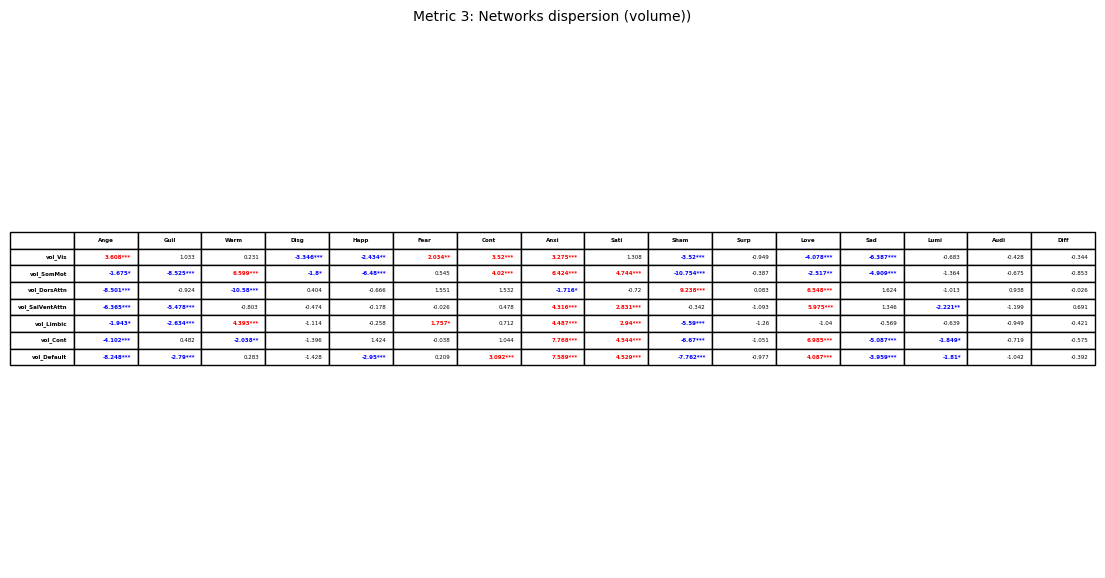

In [19]:
from matplotlib.font_manager import FontProperties

indexes = select + ['Luminance', 'Audio', 'Diffenerg']
indexes = [idx[:4] for idx in indexes]

fig,ax = plt.subplots(1,figsize=(14,7))

# MAKING TABLE
tabling = np.empty((7,len(indexes)+1), dtype=np.object_)
for j in range(len(indexes)+1):
    for i in range(7):
        if j == 0:
            tabling[i,j] = arr3[i]
        else:
            t_meter, _ = glmnet[networks[i]]
            t_meter    = t_meter[j]
            tabling[i,j]      = np.object_(np.round(t_meter,3))

ax.axis('tight')
ax.axis('off')
ax.set_title("Metric 3: Networks dispersion (volume))", size=10)
table = ax.table(cellText=tabling,
                        colLabels=[''] + indexes,
                        loc='center')    

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    if (col == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    # stress on which value is significant against null distribution
    _, pvalues = glmnet[networks[row-1]]
    nscore  = pvalues[col]
    
    nbstars = int(nscore < 0.01) + int(nscore < 0.05) + int(nscore < 0.1)

    if row != 0 and col !=0 :
        if m==4 and row >= 3 : continue
        cell.get_text().set_text(str(tabling[row-1,col]) + '*' * nbstars)

        if nbstars > 0:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            if tabling[row-1,col] > 0:
                cell.get_text().set_color('red')
            else:
                cell.get_text().set_color('blue')
                
#     table.auto_set_font_size(False)
#     table.set_fontsize(5)
#     table.scale(1.03, 1.03)  # may help
# plt.suptitle("Correlation Metric VS Emotion (group) on : {}".format(moviename))
plt.show()

#### GLM reconstruction of emotion from metric regressors

##### Regressor Making

In [20]:
grad_idx = 0
pairs = [("Vis", "Default"), ("SomMot", "Default"), 
        ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
        ("DorsAttn", "Default"), ("Limbic", "Default"), ("Cont", "Default")]
n, _ , _ = G_movie.shape
n        = n - 1 # window reason we resize by -1

regressors = [np.ones(n)]
smfactor   = 1

# #1. Uncomment for inter networks distance
# for idx, pair in enumerate(pairs):
#     p1,p2 = pair
#     y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
#                     for t in range(len(G_movie))])
#     z1 = zscore(y)
#     regressors.append(z1[:n])

# #2. Uncomment for intra networks distance
for idx, R in enumerate(networks):
    y  = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)
    regressors.append(z1[:n])

# #3. Uncomment for explained variance
# for idx, R in enumerate(networks):
#     y  = varM[:,idx]
#     z1 = zscore(y)
#     regressors.append(z1[:n])

regressors = np.stack(regressors)

##### GLM Fitting

In [21]:
table_t   = {}
residuals = {}
beta_fit  = {}
for b in range(len(select)):
    emotion    = select[b]
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
    smoothened = overlap_add(emo_series, smfactor)
    z2         = zscore(smoothened[:n])
    y = deepcopy(z2)

    # regress solving
    X = regressors.T

    beta = (np.linalg.inv(np.matmul(X.T, X)) @ X.T) @ y

    y_hat_meter = X @ beta

    N = y.size
    P = X.shape[1]
    df = (N - P)
    
    sigma_hat = np.sum((y - y_hat_meter) ** 2) / df
    design_variance_weight = design_variance(X, 1)
    
    residuals[emotion] = sigma_hat
    # t-stats
    t_meter  = beta / np.sqrt(sigma_hat * design_variance_weight)

    # multiply by two to create a two-tailed p-value
    p_values = np.array([stats.t.sf(np.abs(t), df) * 2  for t in t_meter])

    table_t[emotion]  = (t_meter,p_values)
    beta_fit[emotion] = beta

##### Reconstruction of the original emotion timecourse

In [36]:
beta_fit[select[-1]]

array([ 0.00272423, -0.06390476, -0.88633105, -0.82108203, -0.49914101,
       -0.68887273, -0.39786146,  1.6706324 ])

Text(0.5, 1.0, 'Reconstruction example')

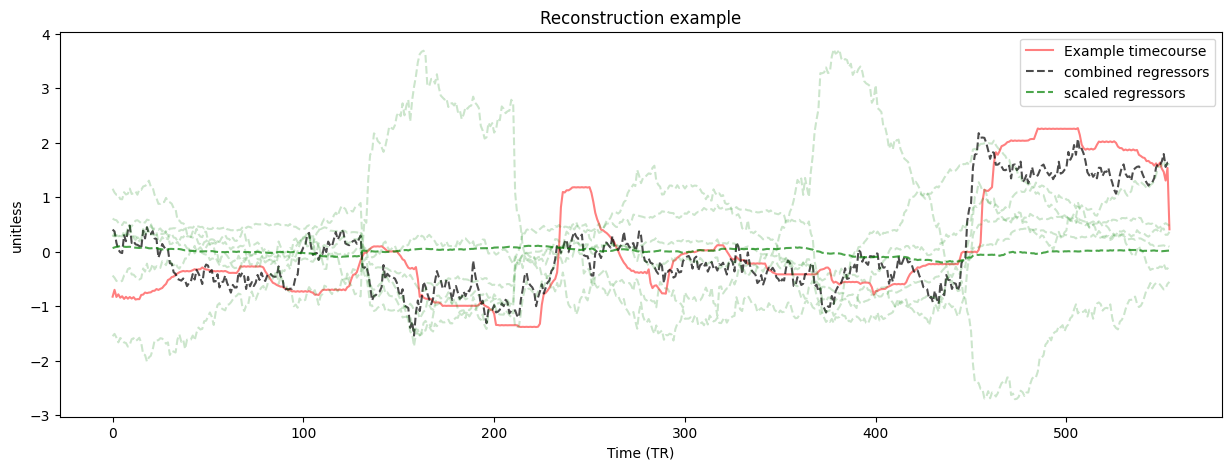

In [46]:
plt.figure(figsize=(15,5))

plt.plot(zscore(np.array(emo_df[emo_df.item==select[-1]]['score'])), label='Example timecourse'.format(select[-1]), c='r', alpha=0.5)
plt.plot(np.matmul(beta_fit[select[-1]], regressors), label='combined regressors', c='k', alpha=0.7, linestyle='--')

for k in range(1,len(beta_fit[select[-1]])):
    if k == 1:
        plt.plot(beta_fit[select[-1]][k] * regressors[k], label='scaled regressors', c='g', alpha=0.7, linestyle='--')
    else:
        plt.plot(beta_fit[select[-1]][k] * regressors[k], c='g', alpha=0.2, linestyle='--')

plt.xlabel('Time (TR)')
plt.ylabel('unitless')
plt.legend()
plt.title('Reconstruction example'.format(select[-1]))

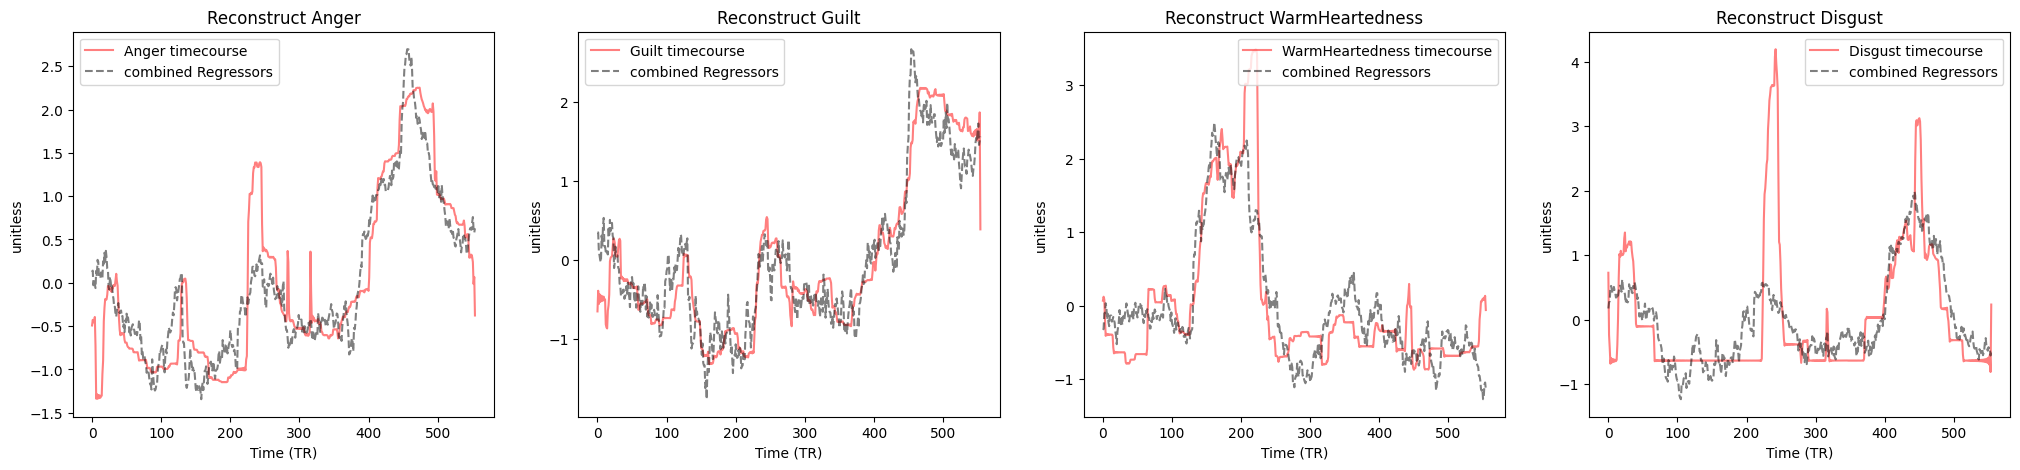

In [23]:
emotions = select[:4]
fig,ax   = plt.subplots(1,4, figsize=(25,5))

for idx, emotion in enumerate(emotions):

    ax[idx].plot(zscore(np.array(emo_df[emo_df.item==emotion]['score'])), label='{} timecourse'.format(emotion), c='r', alpha=0.5)
    ax[idx].plot(np.matmul(beta_fit[emotion], regressors), label='combined Regressors', c='k', alpha=0.5, linestyle='--')
    # print(stats.pearsonr(np.matmul(beta_fit[emotion], regressors), zscore(np.array(emo_df[emo_df.item==emotion]['score']))))
    ax[idx].set_xlabel('Time (TR)')
    ax[idx].set_ylabel('unitless')
    ax[idx].legend()
    ax[idx].set_title('Reconstruct {}'.format(emotion))

##### Metrics/Regressors auto-correlation

In [111]:
# interest = regressors[1:]
betaindex = np.argsort(np.abs(np.asarray(list(beta_fit.values()))[:,1:]).mean(axis=0))[-5:]
interest  = regressors[betaindex]
regress_corr = np.zeros((len(interest),len(interest)))
for k in range(len(interest)):
    for j in range(len(interest)):
        regress_corr[k,j] = stats.pearsonr(interest[k], interest[j]).statistic


Text(0.5, 1.0, "Extracted dynamic gradients' metrics correlation")

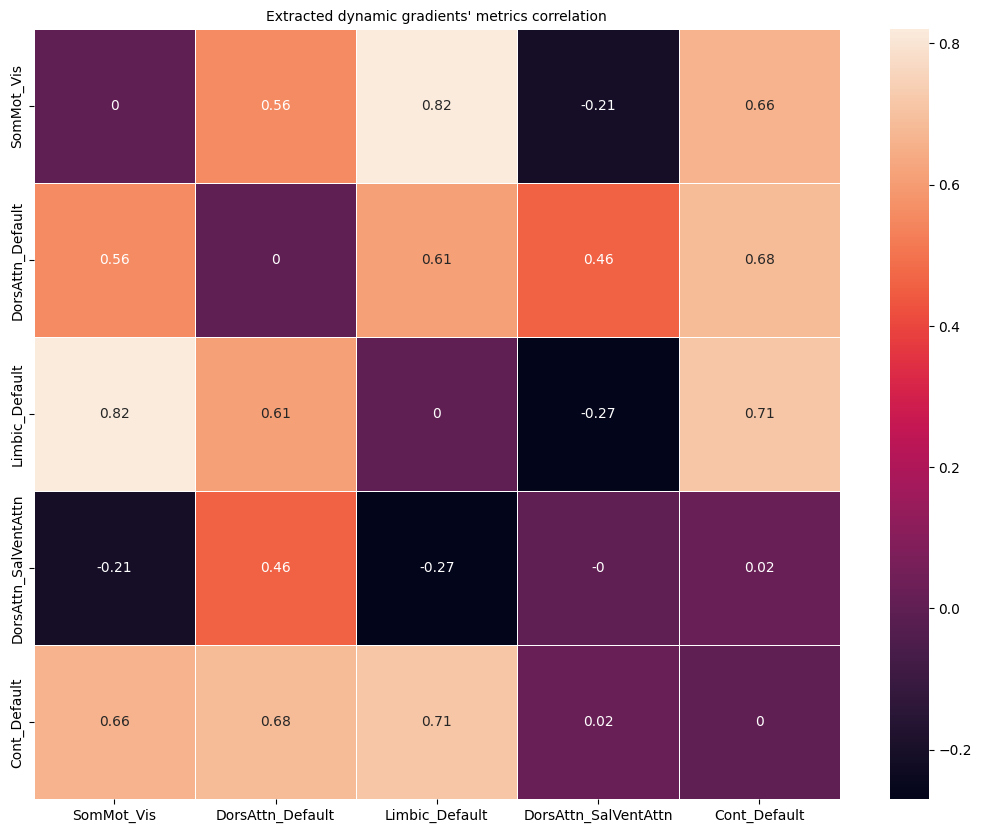

In [112]:
toremove = regress_corr - np.eye(len(interest))

arr1 = [p1+'_'+p2 for (p1,p2) in pairs]
arr3 = ["vol_{}".format(n) for n in networks]
arr4 = ["exp_var_{}".format(n) for n in range(len(networks))]
metrics_name  = np.asarray(arr1 + arr3 + arr4 )
x_axis_labels = metrics_name[betaindex]

plt.figure(figsize=(13,10))
sns.heatmap(np.round(regress_corr - np.eye(len(interest)), 2), linewidth=0.5,  annot=True, xticklabels=x_axis_labels, yticklabels=x_axis_labels)
plt.title("Extracted dynamic gradients' metrics correlation", size=10)
# plt.axis('off')

##### t-statistics of Beta Coefficients

In [116]:
# arr1 = [p1+'_'+p2 for (p1,p2) in pairs]
# arr2 = ["1d_var_{}".format(n) for n in networks]
arr3 = ["vol_{}".format(n) for n in networks]
# arr4 = ["exp_var_{}".format(n) for n in range(len(networks))]
# metrics_name = ['intercept'] + arr1 + arr2 + arr3 + arr4 
metrics_name = ['intercept'] + arr3

(0.0, 1.0, 0.0, 1.0)

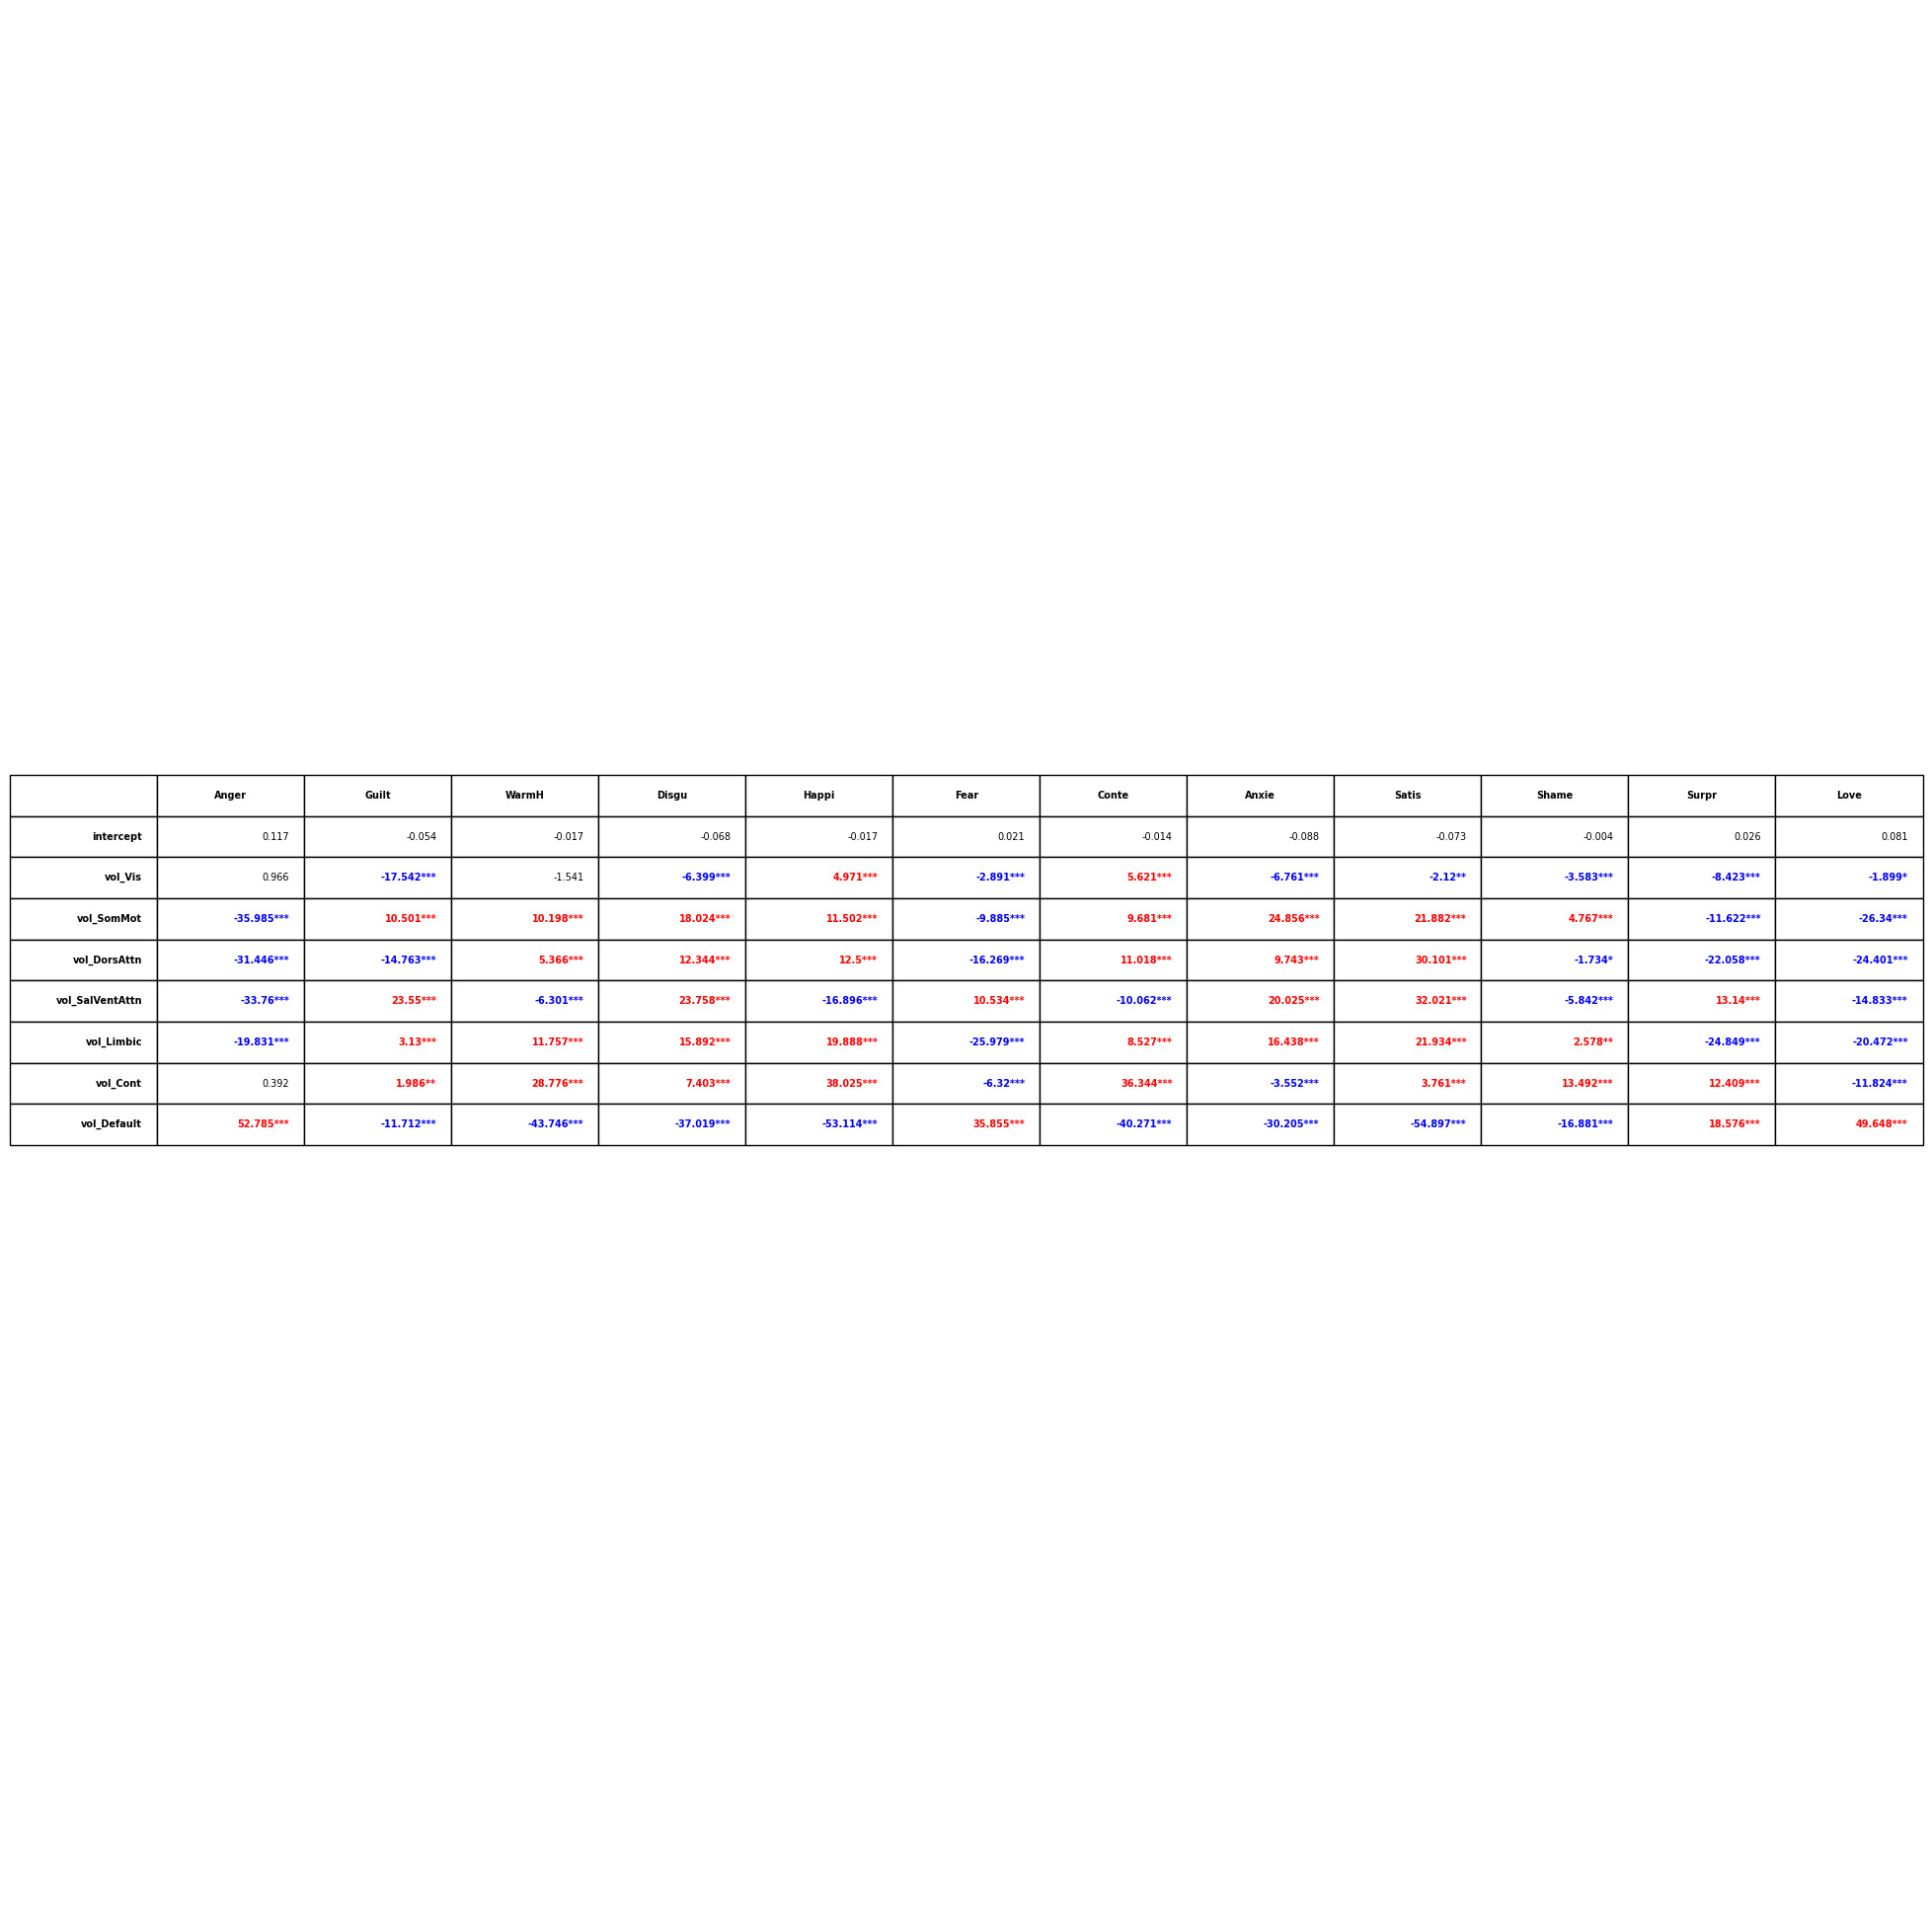

In [118]:
from matplotlib.font_manager import FontProperties

plt.figure(figsize=(10,25))

tabling = np.empty((len(metrics_name),13), dtype=np.object_)
for j in range(13):
    for i in range(len(metrics_name)):
        if j == 0:
            tabling[i,j] = metrics_name[i]
        else:
            emotion = select[j]
            tabling[i,j] = np.object_(np.round(table_t[emotion][0][i],3))


table = plt.table(cellText=tabling,
                        colLabels=[''] + [s[:5] for s in select],
                        loc='center')

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    if (col == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    
    emotion = select[col]
    
    # stress on which value is significant against null distribution
    nscore  = table_t[emotion][1][row-1]
    nbstars = int(nscore < 0.01) + int(nscore < 0.05) + int(nscore < 0.1)
    
    if row != 0 and col !=0 :
        cell.get_text().set_text(str(tabling[row-1,col]) + '*' * nbstars)
        
        if nbstars > 0:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            if float(tabling[row-1,col]) > 0:
                cell.get_text().set_color('red')
            else:
                cell.get_text().set_color('blue')

table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(2.5, 2.5)
plt.axis('off')

### Visualization of correlation between metrics and actual movie with emotion series on the side
Details : Look at on correlation metric strong correlation, 2d joint plot moving over time (with some highlights) versus  movie emotions timeseries.
We choose here:
- Emotion : Anger
- Network : Dorsal Attention
- Metric  : Volume Change

In [3]:
# Compute Metric series
tmp_emo = 'Anger'
net     = 'DorsAttn'

ym  = np.asarray([network_volume(G_movie[t], net) 
                    for t in range(len(G_movie))])

# Find Emotion series
emo_series = np.array(emo_df[emo_df.item==tmp_emo]['score'])
smoothened = overlap_add(emo_series, 1)
ye   = zscore(smoothened[:ym.shape[0]])

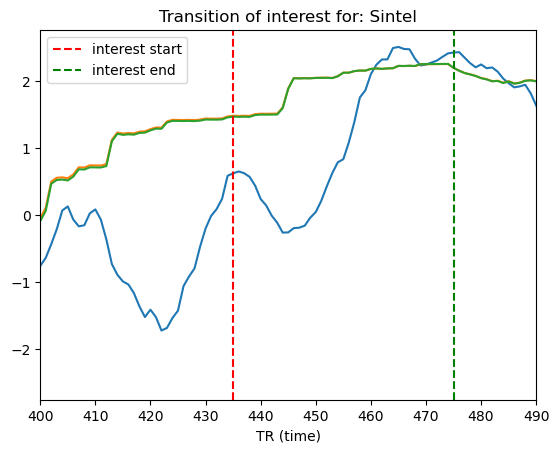

In [4]:
# We want to extract a quick snippet of emotion/metric and watch the corresponding video snippet
plt.plot(zscore(-ym))
# plt.plot(-ym)
plt.plot(ye)
plt.plot(zscore(smoothened))
plt.xlim(400,490)
plt.title('Transition of interest for: {}'.format(moviename))
plt.xlabel('TR (time)')
# We select our snippet to be showing 1 sharp transition, i.e from TR 220 to TR 235 which would give us 15 * TR seconds of movies
moviestart = TR * 435
movieend   = TR * 475
plt.axvline(x=435, linestyle='--', label='interest start', color='r')
plt.axvline(x=475, linestyle='--', label='interest end', color='g')
plt.legend()

In [6]:
fps = 24
start_idx = int(moviestart * fps)
end_idx   = int(movieend * fps)

frames = video2img('./zeal/Sintel_zeal_Surprise.mp4', start_idx=start_idx, end_idx=end_idx)

Display FPS is: 24.0


In [5]:
import moviepy.editor as mp

In [6]:
my_clip = mp.VideoFileClip(r"./zeal/Sintel_zeal_Surprise.mp4")
myclip.audio.write_audiofile("/tmp/data/test.wav",codec='pcm_s16le')

In [7]:
tmp_clip = my_clip.subclip(moviestart, movieend)

In [9]:
tmp_clip.audio.write_audiofile("./audio.wav", codec="pcm_s32le")

chunk:   3%|▎         | 37/1147 [00:47<23:56,  1.29s/it, now=None]

MoviePy - Writing audio in ./audio.wav


chunk:   3%|▎         | 37/1147 [00:48<24:12,  1.31s/it, now=None]

MoviePy - Done.


Text(0, 0.5, 'G2')

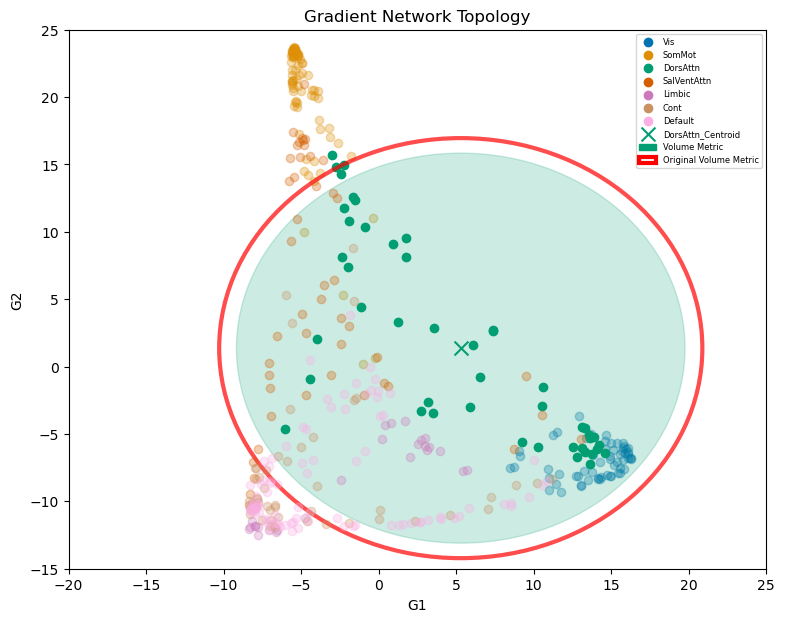

In [14]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
frame  = 100
fig,ax = plt.subplots(figsize=(9,7))
for idx,net in enumerate(networks):

    if net == 'DorsAttn':
        ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
        color=my_cmap.colors[idx], alpha=1, label=net)

        C1 = G_movie[frame,index2region[net],0].mean()
        C2 = G_movie[frame,index2region[net],1].mean()
        ax.scatter(C1, C2, marker='x', s=100,
        color=my_cmap.colors[idx], alpha=1, label=net + '_Centroid')

        R = network_volume(G_movie[frame][:,:2], net)
        circle = plt.Circle((C1, C2), R, color=my_cmap.colors[idx], alpha=0.2, label='Volume Metric')
        ax.add_patch(circle)

        # adding metric circle from the first frame to give a sense of change
        R = network_volume(G_movie[0][:,:2], net)        
        circle = plt.Circle((C1, C2), R, color='r', alpha=0.7, label='Original Volume Metric', fill=False, linewidth = 3)
        ax.add_patch(circle)
    else:
        ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
        color=my_cmap.colors[idx], alpha=0.3, label=net)        


handles, labels = ax.get_legend_handles_labels()
order  = [0,1,2,6,7,8,9,3,4,5]
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=1, prop={'size':6})
for lh in legend.legendHandles: 
    lh.set_alpha(1)
ax.set_title("Gradient Network Topology")
ax.set_xlim(-20,25)
ax.set_ylim(-15,25)
ax.set_xlabel('G1', fontsize=10)
ax.set_ylabel('G2', fontsize=10)

In [17]:
# Generate the corresponding joint plot video
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
for j in tqdm(range(len(G_movie))):
    frame  = j
    fig,ax = plt.subplots(figsize=(9,7))
    for idx,net in enumerate(networks):
        if net == 'DorsAttn':
            ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
            color=my_cmap.colors[idx], alpha=1, label=net)

            C1 = G_movie[frame,index2region[net],0].mean()
            C2 = G_movie[frame,index2region[net],1].mean()
            ax.scatter(C1, C2, marker='x', s=100,
            color=my_cmap.colors[idx], alpha=1, label=net + '_Centroid')

            R = network_volume(G_movie[frame][:,:2], net)
            circle = plt.Circle((C1, C2), R, color=my_cmap.colors[idx], alpha=0.2, label='Volume Metric')
            ax.add_patch(circle)

            # adding metric circle from the first frame to give a sense of change
            R = network_volume(G_movie[435][:,:2], net)        
            circle = plt.Circle((C1, C2), R, color='r', alpha=0.7, label='Original Volume Metric', fill=False, linewidth = 3)
            ax.add_patch(circle)            
        else:
            ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
            color=my_cmap.colors[idx], alpha=0.3, label=net)

            
    handles, labels = ax.get_legend_handles_labels()
    order  = [0,1,2,6,7,8,9,3,4,5]
    legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=1, prop={'size':8})
    for lh in legend.legendHandles: 
        lh.set_alpha(1)
    ax.set_title("Gradient Network Topology")
    ax.set_xlim(-20,25)
    ax.set_ylim(-15,25)
    ax.set_xlabel('G1', fontsize=10)
    ax.set_ylabel('G2', fontsize=10)
    fig.savefig("./media/gradient_plots/{}_{}.jpg".format(moviename,j))
    plt.close("all")

100%|██████████| 516/516 [00:58<00:00,  8.81it/s]


In [18]:
path = "./media/gradient_plots/"

# reorder saved images path
movie_path  = loadimg_in_order([m for m in os.listdir(path)])
movie_array = [cv2.imread(path+'/'+filename) for filename in movie_path]

img2video(movie_array, 10, outpath_name='./media/{}_attention_ws{}.mp4'.format(moviename,40))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [8]:
# Let's combine the images
nbdup = len(frames)//40
images = []
for i in range(435,475):
    path = './media/gradient_plots/{}_{}.jpg'.format(moviename, i)
    for _ in range(nbdup):
        images.append(cv2.imread(path))

In [9]:
images = np.asarray(images)
frames = np.asarray(frames)

In [10]:
padimages = np.asarray([ cv2.resize(images[i] ,(800,544))[:,:,::-1] for i in range(len(images))])

In [11]:
merged = compare_videos(frames[:,:,:,::-1], padimages)

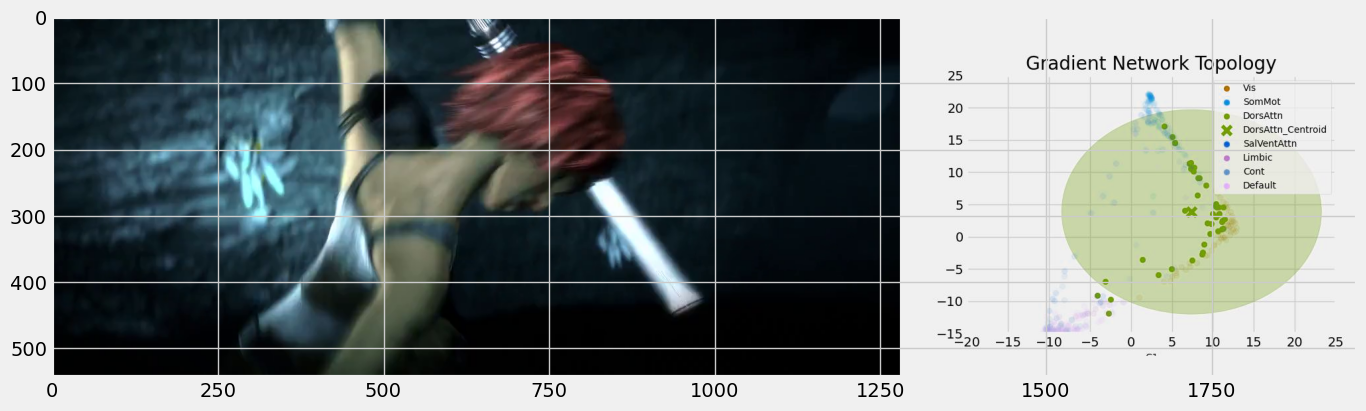

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(merged[0])

In [12]:
img2video(merged[:,:,:,::-1], 24, '24fps.mp4')
# img2video(merged[:,:,:,::-1], 72,' 72fps.mp4')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


: 